In [ ]:
run_project = input("Czy chcesz uruchomić projekt? (tak/nie): ").lower()

if run_project != 'tak':
    raise SystemExit("Projekt nie zostanie uruchomiony.")
print("Projekt uruchomiony.")

## Biblioteki

In [ ]:
!pip install feature_engine
from pathlib import Path
import os
import re
from collections import OrderedDict
from feature_engine.outliers import Winsorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import loguniform, uniform
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    KBinsDiscretizer,
    OneHotEncoder,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
    cross_validate,
    StratifiedShuffleSplit,
)
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    matthews_corrcoef,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from IPython.display import display
import joblib
import kagglehub
import pathlib
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## EDA

Załadowano 100000 wierszy i 9 kolumn.



,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB

Statystyki opisowe:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,100000,3,Female,58552,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,100000.0,NaN,NaN,NaN,41.885856,22.51684,0.08,24.0,43.0,60.0,80.0
hypertension,100000.0,NaN,NaN,NaN,0.07485,0.26315,0.0,0.0,0.0,0.0,1.0
heart_disease,100000.0,NaN,NaN,NaN,0.03942,0.194593,0.0,0.0,0.0,0.0,1.0
smoking_history,100000,6,No Info,35816,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,100000.0,NaN,NaN,NaN,27.320767,6.636783,10.01,23.63,27.32,29.58,95.69
HbA1c_level,100000.0,NaN,NaN,NaN,5.527507,1.070672,3.5,4.8,5.8,6.2,9.0
blood_glucose_level,100000.0,NaN,NaN,NaN,138.05806,40.708136,80.0,100.0,140.0,159.0,300.0
diabetes,100000.0,NaN,NaN,NaN,0.085,0.278883,0.0,0.0,0.0,0.0,1.0



Rozkład klas:


diabetes
Brak cukrzycy    91500
Cukrzyca          8500
Name: count, dtype: int64

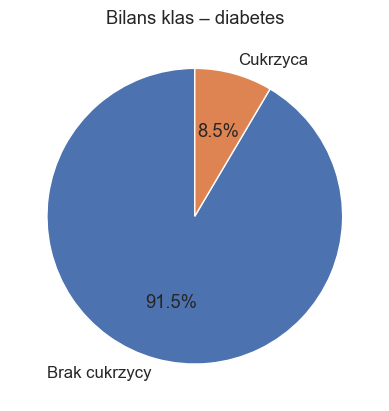


Braki danych w kolumnach:


,Liczba braków
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


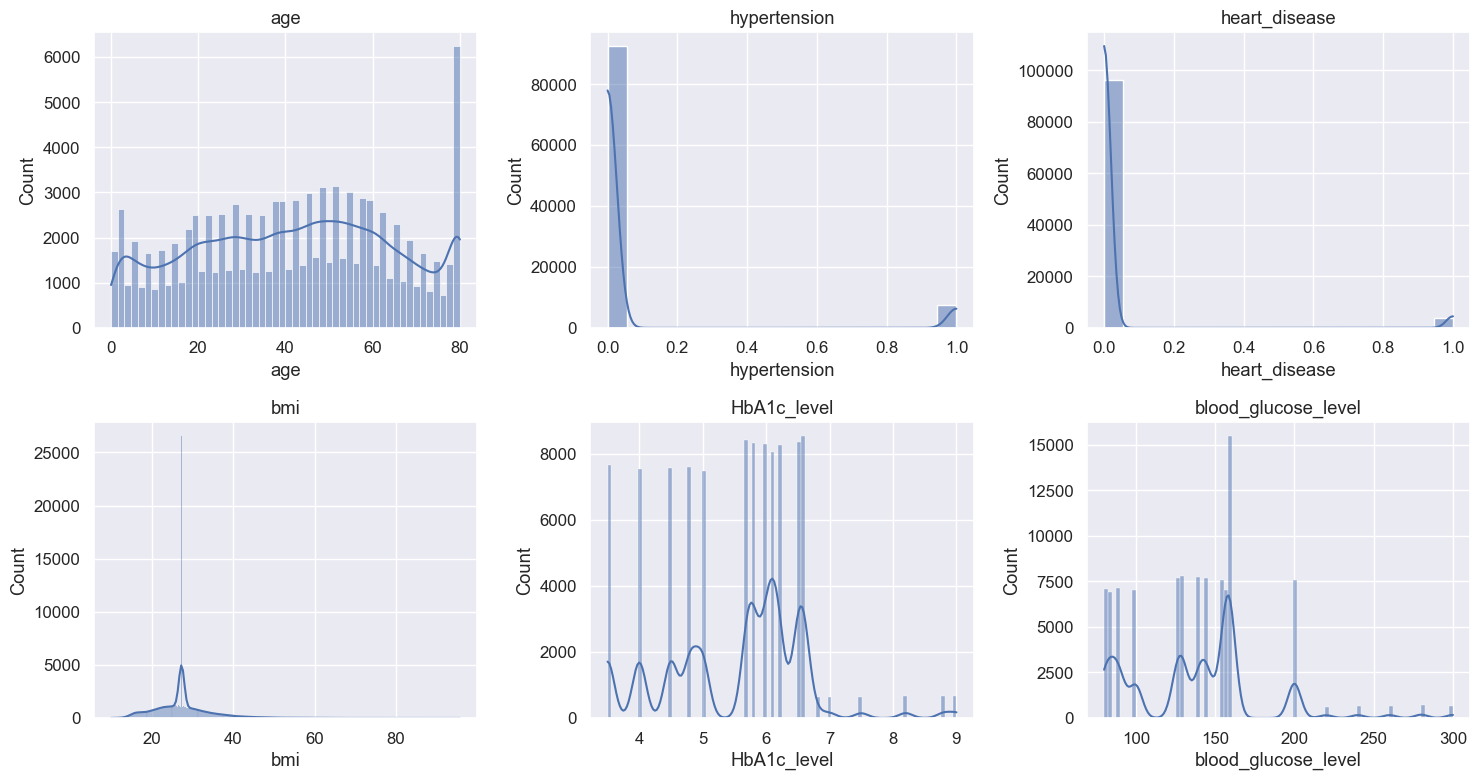

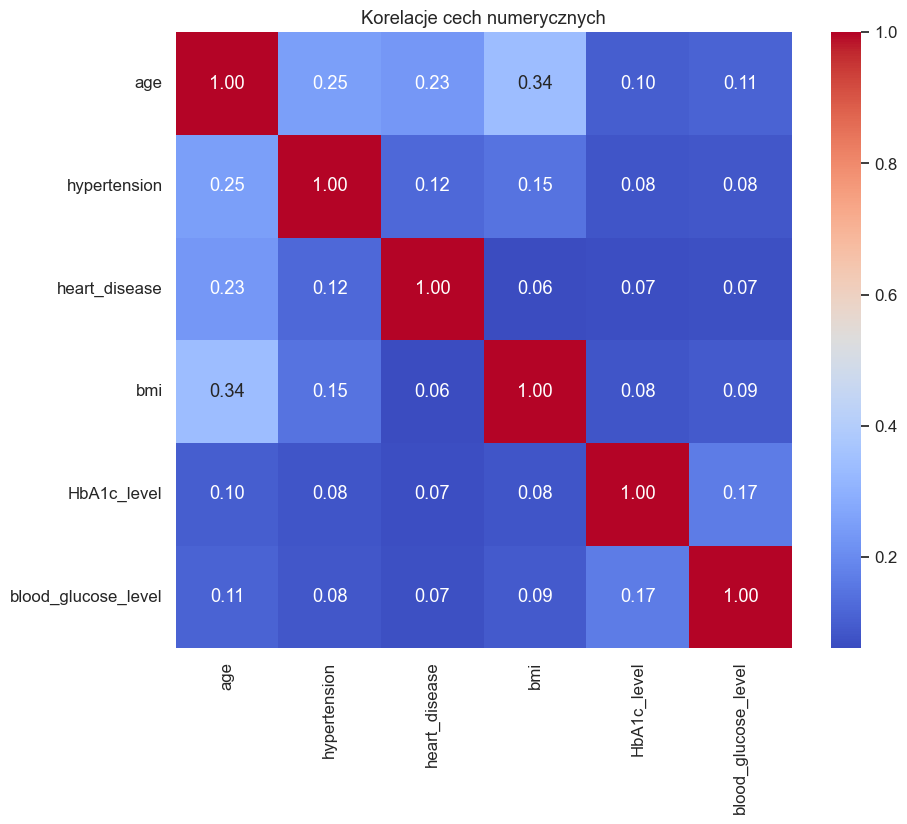

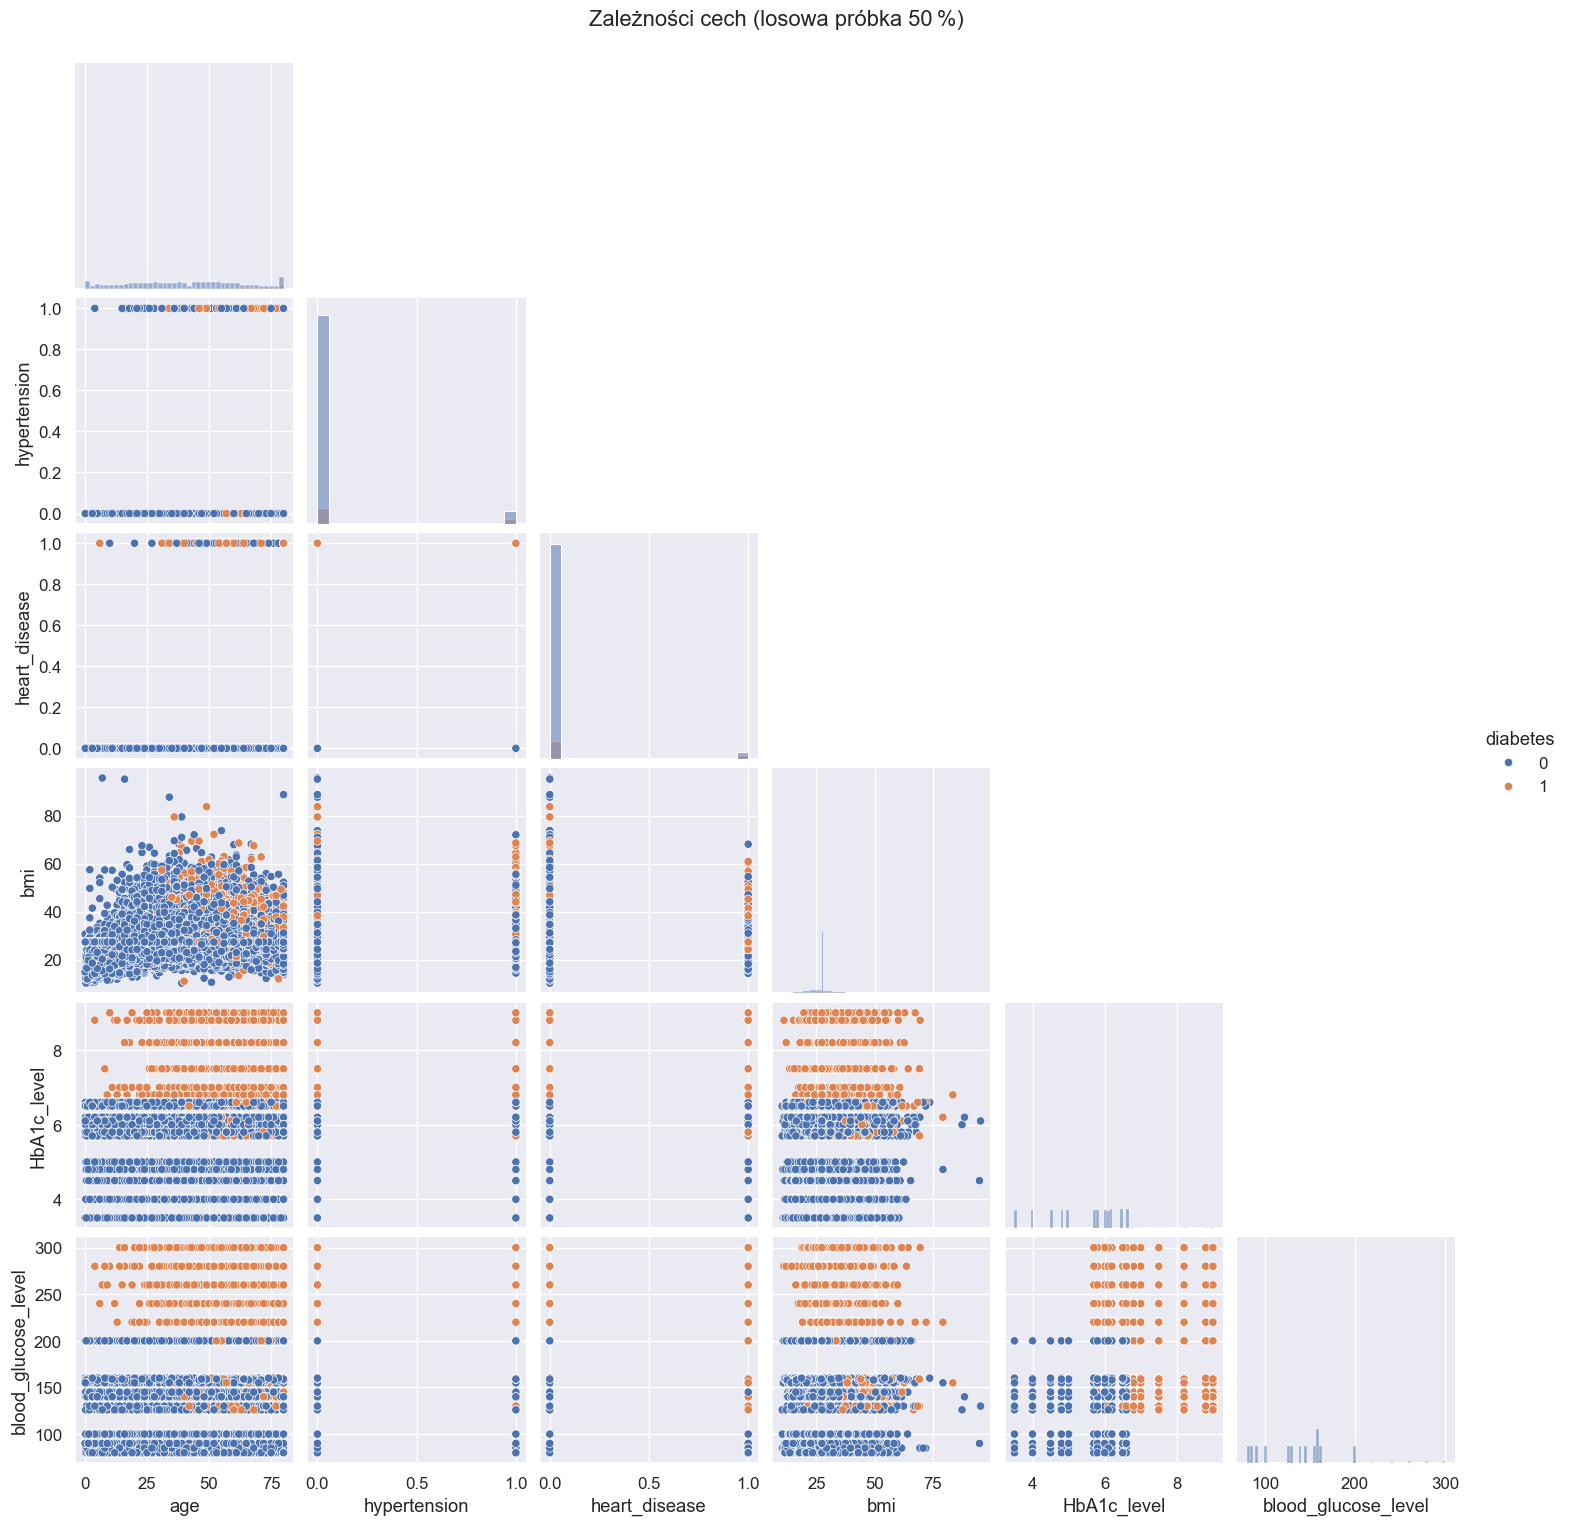

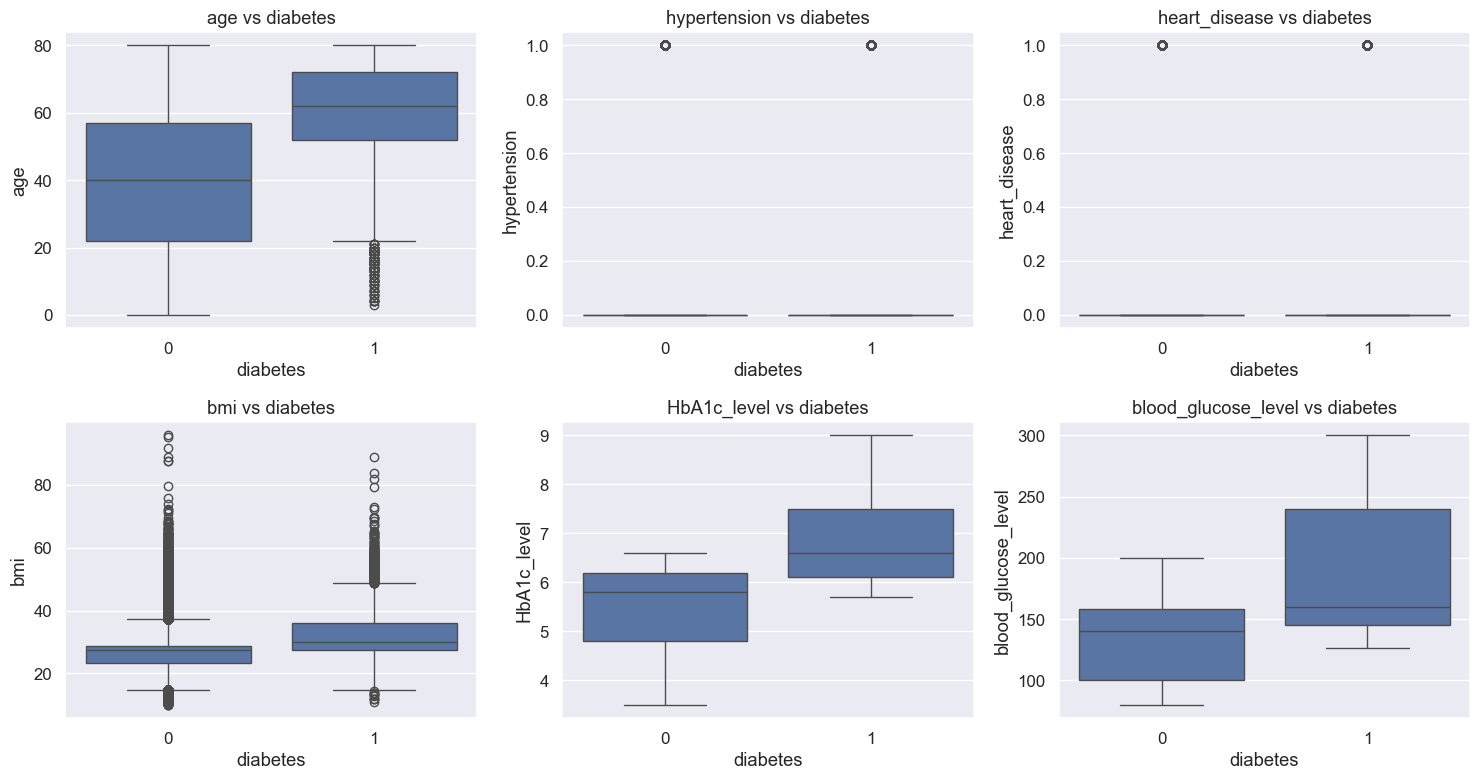

In [ ]:
plt.style.use("default")  # ustawienie stylu
sns.set(font_scale=1.1)  # skalowanie czcionki
pd.set_option("display.max_columns", None)  # pełny widok kolumn

path = kagglehub.dataset_download("iammustafatz/diabetes-prediction-dataset")  # pobranie danych
path = pathlib.Path(path)  # konwersja ścieżki
csv_file = next(path.glob("*.csv"))  # wyszukanie pliku CSV
df = pd.read_csv(csv_file.as_posix())  # wczytanie danych

if df["diabetes"].dtype == object:  # detekcja typu etykiety
    df["diabetes"] = (  # konwersja etykiet
        df["diabetes"]
        .str.strip()  # usunięcie spacji
        .str.lower()  # zmiana na małe litery
        .map({"positive": 1, "yes": 1, "negitive": 0, "negative": 0, "no": 0})  # mapowanie wartości
        .astype(int)  # typ liczbowy
    )

target = "diabetes"  # zmienna celu
feature_cols = df.columns.drop(target)  # wybór cech

print(f"Załadowano {df.shape[0]} wierszy i {df.shape[1]} kolumn.\n")  # podsumowanie rozmiaru
display(df.head())  # podgląd danych
df.info()  # struktura DataFrame

print("\nStatystyki opisowe:")  # nagłówek statystyk
display(df.describe(include="all").T)  # statystyki opisowe

class_counts = df[target].value_counts().rename(index={0: "Brak cukrzycy", 1: "Cukrzyca"})  # zliczenie klas
print("\nRozkład klas:")  # nagłówek rozkładu
display(class_counts)  # wyświetlenie rozkładu

fig, ax = plt.subplots()  # inicjalizacja wykresu
ax.pie(class_counts, labels=class_counts.index, autopct="%1.1f%%", startangle=90)  # wykres kołowy klas
ax.set_title(f"Bilans klas – {target}")  # tytuł wykresu
plt.show()  # wyświetlenie wykresu

missing_summary = df.isna().sum().to_frame("Liczba braków")  # podsumowanie braków
print("\nBraki danych w kolumnach:")  # nagłówek braków
display(missing_summary)  # wyświetlenie braków

num_cols = df[feature_cols].select_dtypes(include="number").columns  # cechy numeryczne
n = len(num_cols)  # liczba cech numerycznych
cols = 3  # kolumny wykresów
rows = (n + cols - 1) // cols  # wiersze wykresów
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))  # siatka wykresów
axes = axes.flatten()  # spłaszczenie osi
for ax, col in zip(axes, num_cols):  # iteracja po cechach numerycznych
    sns.histplot(df[col], kde=True, ax=ax)  # histogram z KDE
    ax.set_title(col)  # tytuł wykresu
for ax in axes[len(num_cols):]:  # pozostałe puste osie
    ax.axis("off")  # wyłączenie osi
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresów

corr = df[num_cols].corr()  # macierz korelacji
plt.figure(figsize=(10, 8))  # rozmiar mapy cieplnej
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)  # mapa cieplna korelacji
plt.title("Korelacje cech numerycznych")  # tytuł mapy
plt.show()  # wyświetlenie mapy

sns.pairplot(df.sample(frac=0.5, random_state=42), hue=target,
             vars=num_cols, diag_kind="hist", corner=True)  # analiza par cech
plt.suptitle("Zależności cech (losowa próbka 50 %)", y=1.02)  # tytuł zbiorczy
plt.show()  # wyświetlenie pairplot

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))  # siatka wykresów pudełkowych
axes = axes.flatten()  # spłaszczenie osi
for ax, col in zip(axes, num_cols):  # iteracja po cechach
    sns.boxplot(x=target, y=col, data=df, ax=ax)  # wykres pudełkowy
    ax.set_title(f"{col} vs {target}")  # tytuł wykresu
for ax in axes[len(num_cols):]:  # pozostałe puste osie
    ax.axis("off")  # wyłączenie osi
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresów pudełkowych


## Preprocessing

In [ ]:
target = "diabetes"  # etykieta
feature_cols = df.columns.drop(target)  # cechy

X = df[feature_cols].copy()  # dane wejściowe
y = df[target].copy()  # etykiety

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,  # udział testu
    stratify=y,  # stratifikacja
    random_state=42  # ziarno losowości
)

class Winsorizer(BaseEstimator, TransformerMixin):  # przycinanie wartości
    def __init__(self, lower_q=0.01, upper_q=0.99):  # kwantyle
        self.lower_q = lower_q
        self.upper_q = upper_q

    def fit(self, X, y=None):  # dopasowanie progów
        arr = X if isinstance(X, np.ndarray) else X.to_numpy()  # konwersja
        q_low  = np.nanquantile(arr, self.lower_q, axis=0)  # dolny kwantyl
        q_high = np.nanquantile(arr, self.upper_q, axis=0)  # górny kwantyl
        self.bounds_ = np.vstack([q_low, q_high]).T  # macierz progów
        return self

    def transform(self, X):  # przycinanie
        arr = X if isinstance(X, np.ndarray) else X.to_numpy()  # konwersja
        for i in range(arr.shape[1]):  # iteracja
            lo, hi = self.bounds_[i]  # zakres
            arr[:, i] = np.clip(arr[:, i], lo, hi)  # przycięcie
        return arr
    def get_feature_names_out(self, input_features=None):  # nazwy cech
        return np.asarray(
            input_features
            if input_features is not None
            else self.feature_names_in_,
            dtype=object,
        )

numeric_cols     = df[feature_cols].select_dtypes(include="number").columns.tolist()  # cechy numeryczne
categorical_cols = df[feature_cols].select_dtypes(exclude="number").columns.tolist()  # cechy kategoryczne

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # imputacja medianą
    ("winsor",  Winsorizer(0.01, 0.99)),  # winsoryzacja
    ("scaler",  StandardScaler()),  # skalowanie
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # imputacja najczęstsza
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),  # kodowanie one-hot
])

preprocess_ct = ColumnTransformer([
    ("num", num_pipe, numeric_cols),  # przetwarzanie numerycznych
    ("cat", cat_pipe, categorical_cols),  # przetwarzanie kategorycznych
], remainder="drop")  # odrzucenie

prep_pipeline = ImbPipeline([
    ("preprocess",  preprocess_ct),  # etap preprocessingu
    ("undersample", RandomUnderSampler(random_state=42)),  # undersampling
])

X_train_proc, y_train_bal = prep_pipeline.fit_resample(X_train, y_train)  # dopasowanie i balans
X_test_proc = prep_pipeline.named_steps["preprocess"].transform(X_test)  # transformacja testu

print(f"Po preprocessingu: X_train={X_train_proc.shape}, X_test={X_test_proc.shape}")  # podsumowanie
print("Rozkład klas po undersamplingu w train:", np.bincount(y_train_bal))  # rozkład klas


Po preprocessingu: X_train=(13600, 15), X_test=(20000, 15)
Rozkład klas po undersamplingu w train: [6800 6800]


## EDA po preprocessingu

Przetworzone kolumny: 15


,num__age,num__hypertension,num__heart_disease,num__bmi,num__HbA1c_level,num__blood_glucose_level,cat__gender_Female,cat__gender_Male,cat__gender_Other,cat__smoking_history_No Info,cat__smoking_history_current,cat__smoking_history_ever,cat__smoking_history_former,cat__smoking_history_never,cat__smoking_history_not current
0,-1.283419,-0.284414,-0.202792,0.007358,0.631660,-1.318461,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.883806,-0.284414,-0.202792,0.007358,-1.430891,1.545349,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.350990,-0.284414,-0.202792,1.002120,0.256650,0.524338,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.839405,-0.284414,-0.202792,1.330580,0.912916,0.524338,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.403833,-0.284414,-0.202792,0.046460,0.256650,-0.297451,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


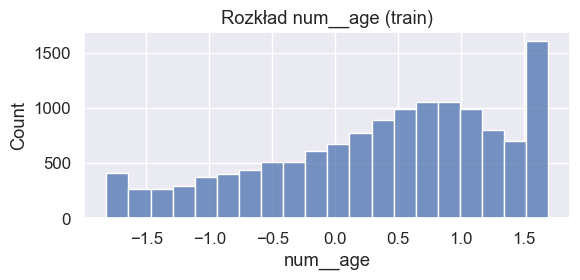

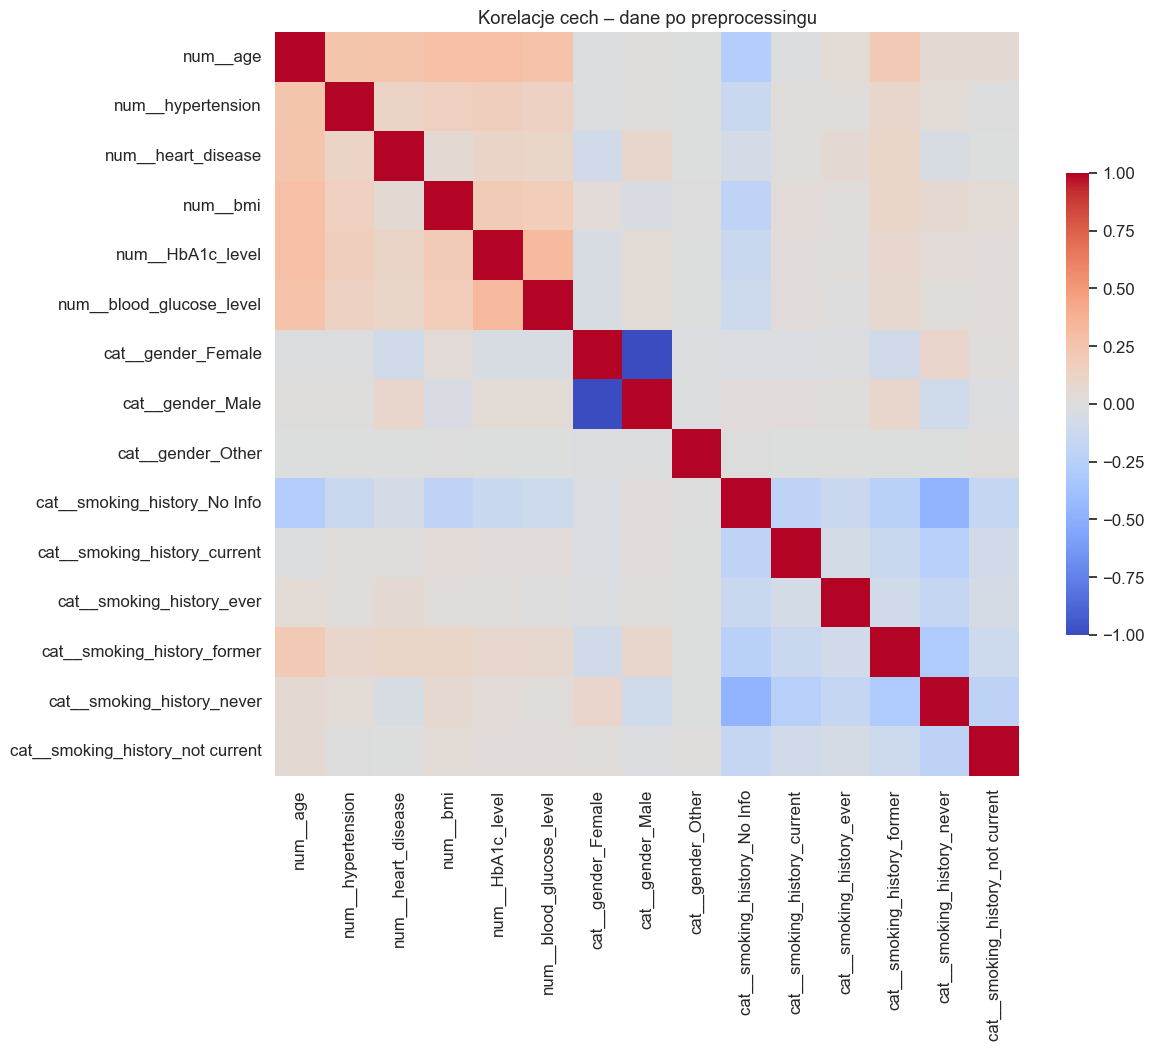

C:\Users\Marlena\AppData\Local\Temp\ipykernel_20872\385249932.py:31: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Marlena\venv_gpu\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


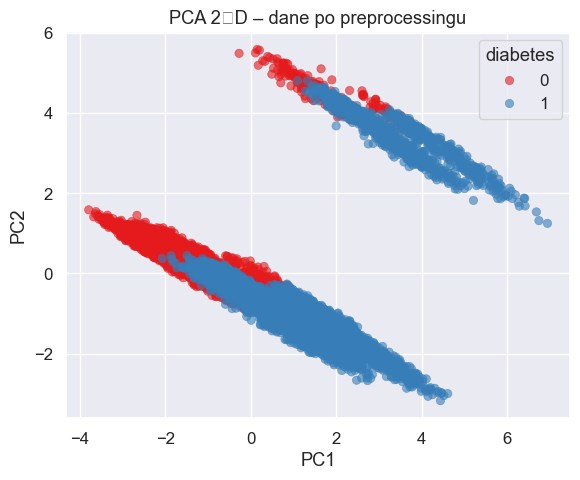

Bilans klas w zbiorze train po preprocessingu:


diabetes
Brak cukrzycy    6800
Cukrzyca         6800
Name: count, dtype: int64

In [ ]:
ct = prep_pipeline.named_steps["preprocess"]  # pobranie preprocessingu
proc_cols = ct.get_feature_names_out()  # nazwy cech po preprocessingu
X_train_df = pd.DataFrame(X_train_proc, columns=proc_cols)  # utworzenie DataFrame

print("Przetworzone kolumny:", len(proc_cols))  # liczba kolumn
display(X_train_df.head())  # podgląd pierwszych wierszy

plt.figure(figsize=(6, 3))  # inicjalizacja wykresu
sns.histplot(X_train_df[proc_cols[0]], kde=False, bins=20)  # histogram cechy
plt.title(f"Rozkład {proc_cols[0]} (train)")  # tytuł wykresu
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresu

corr_proc = X_train_df.corr()  # macierz korelacji
plt.figure(figsize=(12, 10))  # rozmiar mapy cieplnej
sns.heatmap(corr_proc, cmap="coolwarm", center=0, square=True,
            cbar_kws={"shrink": .6}, vmax=1, vmin=-1)  # wykres korelacji
plt.title("Korelacje cech – dane po preprocessingu")  # tytuł mapy
plt.show()  # wyświetlenie mapy

from sklearn.decomposition import PCA  # import PCA
pca = PCA(n_components=2, random_state=42)  # inicjalizacja PCA
proj = pca.fit_transform(X_train_df)  # projekcja danych na 2D
plt.figure(figsize=(6, 5))  # inicjalizacja wykresu PCA
sns.scatterplot(x=proj[:, 0], y=proj[:, 1],
                hue=y_train_bal.reset_index(drop=True),
                palette="Set1", alpha=.6, edgecolor=None)  # wykres punktowy PCA
plt.title("PCA 2-D – dane po preprocessingu")  # tytuł wykresu
plt.xlabel("PC1"); plt.ylabel("PC2")  # etykiety osi
plt.legend(title="diabetes")  # legenda
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresu

print("Bilans klas w zbiorze train po preprocessingu:")  # nagłówek bilansu klas
display(pd.Series(y_train_bal).value_counts()
        .rename(index={0: "Brak cukrzycy", 1: "Cukrzyca"}))  # wyświetlenie rozkładu klas


## Trening+Hiperparametry

In [ ]:
models_dir = Path(os.getcwd()) / "models"  # katalog modeli
models_dir.mkdir(parents=True, exist_ok=True)  # utworzenie katalogu, jeśli nie istnieje

def tune_then_refit(estimator, param_dist, n_iter, X_full, y_full,
                    sample_frac=0.1, cv_splits=5, tag="model"):  # funkcja strojenia i refit
    sss = StratifiedShuffleSplit(  # konfiguracja próbki stratifikowanej
        n_splits=1,  # jedna iteracja
        test_size=1 - sample_frac,  # rozmiar testu dla próbki
        random_state=42  # ziarno losowości
    )
    sample_idx, _ = next(sss.split(X_full, y_full))  # indeksy próbki
    X_sample, y_sample = X_full[sample_idx], y_full[sample_idx]  # wyodrębnienie próbki

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)  # walidacja krzyżowa
    search = RandomizedSearchCV(  # konfiguracja RandomizedSearchCV
        estimator, param_dist, n_iter=n_iter, scoring="roc_auc",  # metryka AUC
        cv=cv, random_state=42, n_jobs=-1, verbose=0  # parametry CV
    )
    search.fit(X_sample, y_sample)  # strojenie na próbce

    best = search.best_estimator_  # najlepszy estymator
    best.fit(X_full, y_full)  # dopasowanie do pełnych danych
    joblib.dump(best, models_dir / f"{tag}.joblib")  # zapis modelu
    print(f"{tag}: best params {search.best_params_}")  # wyświetlenie najlepszych parametrów
    return best  # zwrócenie modelu

X_train_np = np.asarray(X_train_proc)  # konwersja cech treningowych do numpy
y_train_np = np.asarray(y_train_bal)  # konwersja etykiet treningowych do numpy
cv_splits = 5  # liczba podziałów w walidacji

# 1) SVM linear
tune_then_refit(
    SVC(kernel="linear", probability=True, random_state=42),  # konfiguracja SVM liniowego
    {"C": loguniform(1e-3, 1e3)},  # zakres regularyzacji
    n_iter=20,  # liczba prób strojenia
    X_full=X_train_np,  # pełne dane treningowe
    y_full=y_train_np,  # pełne etykiety treningowe
    tag="svm_simple"  # nazwa modelu
)

# 2) SVM RBF
tune_then_refit(
    SVC(kernel="rbf", probability=True, random_state=42),  # konfiguracja SVM RBF
    {"C": loguniform(1e-3, 1e3),
     "gamma": loguniform(1e-4, 1e-1)},  # zakres parametrów C i gamma
    n_iter=40,  # liczba prób strojenia
    X_full=X_train_np,  # pełne dane treningowe
    y_full=y_train_np,  # pełne etykiety treningowe
    tag="svm_mid"  # nazwa modelu
)

# 3) SVM poly
tune_then_refit(
    SVC(kernel="poly", probability=True, random_state=42),  # konfiguracja SVM wielomianowego
    {"C": loguniform(1e-3, 1e3),
     "gamma": loguniform(1e-4, 1e-1),
     "degree": [2, 3, 4],  # stopnie wielomianu
     "coef0": uniform(0, 1)},  # współczynnik niezależny
    n_iter=60,  # liczba prób strojenia
    X_full=X_train_np,  # pełne dane treningowe
    y_full=y_train_np,  # pełne etykiety treningowe
    tag="svm_advanced"  # nazwa modelu
)


svm_simple: best params {'C': np.float64(157.41890047456639)}
svm_mid: best params {'C': np.float64(93.84800715909533), 'gamma': np.float64(0.0011756010900231862)}
svm_advanced: best params {'C': np.float64(241.70996068266953), 'coef0': np.float64(0.9004180571633305), 'degree': 4, 'gamma': np.float64(0.00036823182895763664)}


SVC(C=np.float64(241.70996068266953), coef0=np.float64(0.9004180571633305),
    degree=4, gamma=np.float64(0.00036823182895763664), kernel='poly',
    probability=True, random_state=42)

## Ewaluacja

,CV_ROC_AUC,CV_Accuracy,CV_BalAcc,CV_Precision,CV_Recall,CV_F1,Test_Accuracy,Test_BalAcc,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC,Test_PR_AUC,Test_MCC
Model,,,,,,,,,,,,,,
Simple,0.963,0.885,0.885,0.885,0.885,0.885,0.887,0.891,0.421,0.897,0.573,0.963,0.817,0.567
Mid,0.963,0.887,0.887,0.884,0.890,0.887,0.885,0.892,0.419,0.901,0.572,0.963,0.813,0.566
Advanced,0.963,0.885,0.885,0.885,0.887,0.886,0.887,0.893,0.422,0.900,0.575,0.963,0.815,0.569


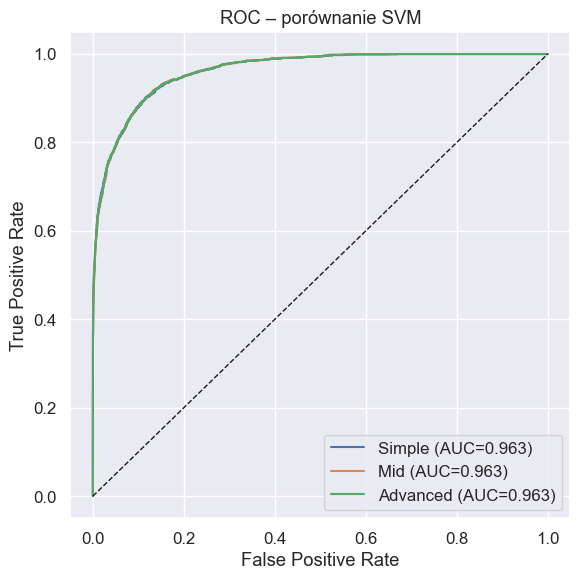

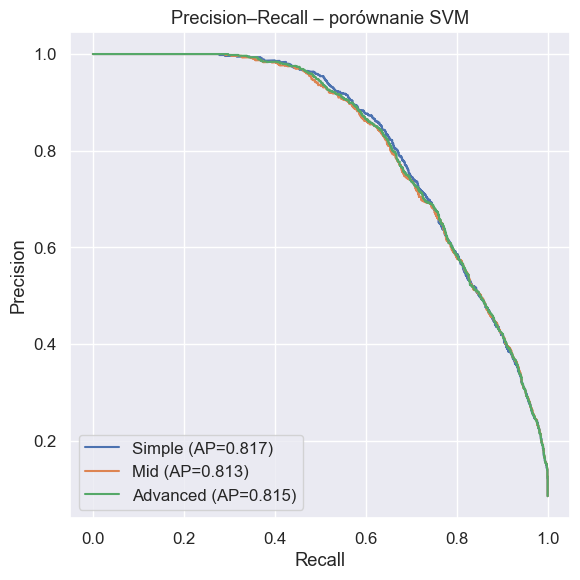

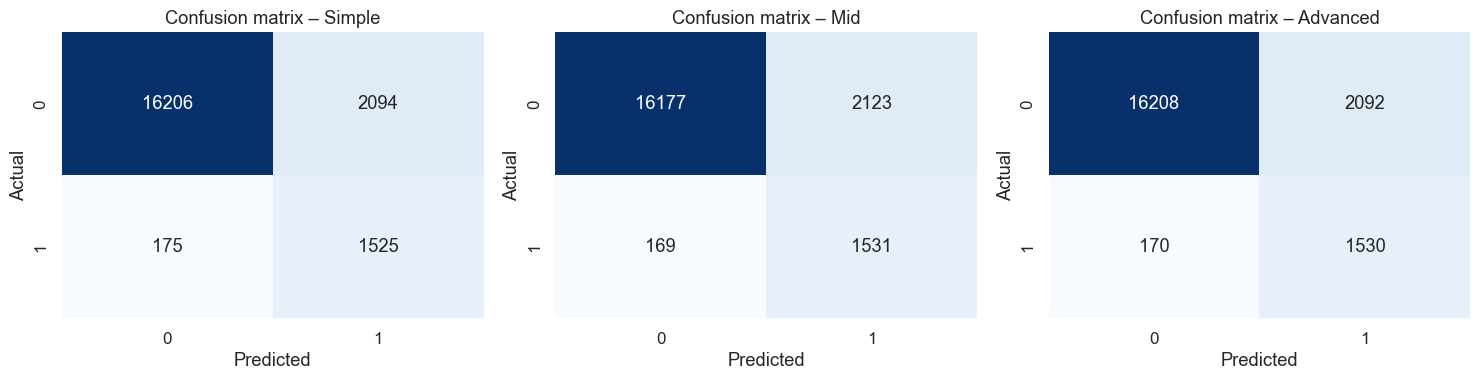

In [ ]:
models_dir = Path(os.getcwd()) / "models"  # katalog modeli
models = {
    "Simple":   joblib.load(models_dir / "svm_simple.joblib"),  # wczytanie prostego SVM
    "Mid":      joblib.load(models_dir / "svm_mid.joblib"),     # wczytanie średniego SVM
    "Advanced": joblib.load(models_dir / "svm_advanced.joblib"),# wczytanie zaawansowanego SVM
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # walidacja krzyżowa
records = []  # zbiór wyników
curves = {}   # słownik krzywych

for tag, model in models.items():  # iteracja po modelach
    cv_res = cross_validate(
        model,
        X_train_proc,
        y_train_bal,
        cv=cv,
        scoring={  # metryki CV
            "ROC_AUC": "roc_auc",
            "Accuracy": "accuracy",
            "BalAcc": "balanced_accuracy",
            "Precision": "precision",
            "Recall": "recall",
            "F1": "f1",
        },
        n_jobs=-1,
        return_train_score=False
    )

    y_proba = model.predict_proba(X_test_proc)[:, 1]  # prawdopodobieństwa klasy 1
    y_pred = model.predict(X_test_proc)  # predykcje

    rec = {
        "Model":        tag,  # nazwa modelu
        "CV_ROC_AUC":   cv_res["test_ROC_AUC"].mean(),    # średnie AUC CV
        "CV_Accuracy":  cv_res["test_Accuracy"].mean(),   # średnia Accuracy CV
        "CV_BalAcc":    cv_res["test_BalAcc"].mean(),     # średnie BalAcc CV
        "CV_Precision": cv_res["test_Precision"].mean(),  # średnie Precision CV
        "CV_Recall":    cv_res["test_Recall"].mean(),     # średnie Recall CV
        "CV_F1":        cv_res["test_F1"].mean(),         # średnie F1 CV
        "Test_Accuracy":       accuracy_score(y_test, y_pred),      # Accuracy testu
        "Test_BalAcc":         balanced_accuracy_score(y_test, y_pred),  # BalAcc testu
        "Test_Precision":      precision_score(y_test, y_pred, zero_division=0),  # Precision testu
        "Test_Recall":         recall_score(y_test, y_pred, zero_division=0),     # Recall testu
        "Test_F1":             f1_score(y_test, y_pred, zero_division=0),         # F1 testu
        "Test_ROC_AUC":        roc_auc_score(y_test, y_proba),       # AUC ROC testu
        "Test_PR_AUC":         average_precision_score(y_test, y_proba),  # AUC PR testu
        "Test_MCC":            matthews_corrcoef(y_test, y_pred),    # współczynnik MCC
    }
    records.append(rec)  # dodanie do listy

    fpr, tpr, _ = roc_curve(y_test, y_proba)  # punkty krzywej ROC
    prec, rec_, _ = precision_recall_curve(y_test, y_proba)  # punkty krzywej PR
    curves[tag] = {"fpr": fpr, "tpr": tpr, "prec": prec, "rec": rec_}  # zapis krzywych

metrics_df = pd.DataFrame(records).set_index("Model").round(3)  # DataFrame metryk
display(metrics_df)  # wyświetlenie metryk

plt.figure(figsize=(6, 6))  # inicjalizacja wykresu ROC
for tag, pts in curves.items():  # iteracja po krzywych
    auc = metrics_df.loc[tag, "Test_ROC_AUC"]  # odczyt AUC ROC
    plt.plot(pts["fpr"], pts["tpr"], label=f"{tag} (AUC={auc:.3f})")  # rysowanie krzywej
plt.plot([0, 1], [0, 1], "k--", lw=1)  # linia losowa
plt.xlabel("False Positive Rate")  # oś X
plt.ylabel("True Positive Rate")  # oś Y
plt.title("ROC – porównanie SVM")  # tytuł
plt.legend()  # legenda
plt.tight_layout()  # układ wykresu
plt.show()  # wyświetlenie

plt.figure(figsize=(6, 6))  # inicjalizacja wykresu Precision–Recall
for tag, pts in curves.items():  # iteracja po krzywych
    ap = metrics_df.loc[tag, "Test_PR_AUC"]  # odczyt AUC PR
    plt.plot(pts["rec"], pts["prec"], label=f"{tag} (AP={ap:.3f})")  # rysowanie krzywej
plt.xlabel("Recall")  # oś X
plt.ylabel("Precision")  # oś Y
plt.title("Precision–Recall – porównanie SVM")  # tytuł
plt.legend()  # legenda
plt.tight_layout()  # układ wykresu
plt.show()  # wyświetlenie

SHOW_CM = True  # flaga macierzy pomyłek
if SHOW_CM:
    fig, axes = plt.subplots(1, len(models), figsize=(5*len(models), 4))  # siatka wykresów
    for ax, (tag, model) in zip(axes, models.items()):  # iteracja po modelach
        cm = confusion_matrix(y_test, model.predict(X_test_proc))  # macierz pomyłek
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)  # wykres macierzy
        ax.set_title(f"Confusion matrix – {tag}")  # tytuł
        ax.set_xlabel("Predicted")  # oś X
        ax.set_ylabel("Actual")  # oś Y
    plt.tight_layout()  # układ wykresów
    plt.show()  # wyświetlenie macierzy
